In [13]:
import numpy as np
import netCDF4 as nc
import os
import scipy as sc, scipy.io
from pyproj import Proj, Geod, transform
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [3]:
bathy_file = scipy.io.netcdf_file('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/IBCAO_V3_500m_RR.grd')
x = bathy_file.variables['x'][:]
y = bathy_file.variables['y'][:]
z = bathy_file.variables['z'][:]

In [4]:
coord_file = nc.Dataset('/ocean/imachuca/Canyons/mackenzie_canyon/bathymetry/grid/tests_coordinates/coords_mack06.nc')
lon = coord_file['nav_lon']
lat = coord_file['nav_lat']

In [5]:
lon_geogr = [lon[0,0], lon[0,-1], lon[-1,0], lon[-1,-1]]
lat_geogr = [lat[0,0], lat[0,-1], lat[-1,0], lat[-1,-1]]
lon_geogr, lat_geogr

([-143.19904, -135.688, -141.80234, -133.16815],
 [68.805038, 69.141022, 71.638969, 71.888832])

In [6]:
def convert_corners(proj_from, proj_to, corner_lons, corner_lats, unit, rads):
    ''' Converts the coordinates of the domain corner points
    from the projection proj_from to the projection proj_to.
    The tranformed coordinates are returned.
    '''
    transformed_lons = []
    transformed_lats = []
    for i in np.arange(len(corner_lons)):
        transformed_x, transformed_y = transform(proj_from, proj_to, corner_lons[i], corner_lats[i], radians = rads)
        transformed_lons.append(transformed_x)
        transformed_lats.append(transformed_y)
    if unit =='km':
        transformed_lons = [x / 1000 for x in transformed_lons]
        transformed_lats = [x / 1000 for x in transformed_lats]
    else:
        pass
    return transformed_lons, transformed_lats

In [7]:
proj_geogr = Proj("+init=EPSG:4326") # Geographical coordinate system
proj_stere = Proj("+init=EPSG:3996") # IBCAO polar stereographic

lon_stere, lat_stere = convert_corners(proj_geogr, proj_stere, lon_geogr, lat_geogr, None, False)
lon_stere, lat_stere

([-1409449.2100267042,
  -1617003.3682287391,
  -1256922.872481835,
  -1461984.957754068],
 [1883983.535291311, 1656310.977343236, 1597398.1611571575, 1371366.776556685])

In [19]:
xl=-1800000; xr=-700000; yb=1200000; yt=2000000
xmin = np.where(x==xl)[0][0]
xmax = np.where(x==xr)[0][0]
ymin = np.where(y==yb)[0][0]
ymax = np.where(y==yt)[0][0]
xn = x[xmin:xmax]
yn = y[ymin:ymax]
zn = z[ymin:ymax, xmin:xmax]

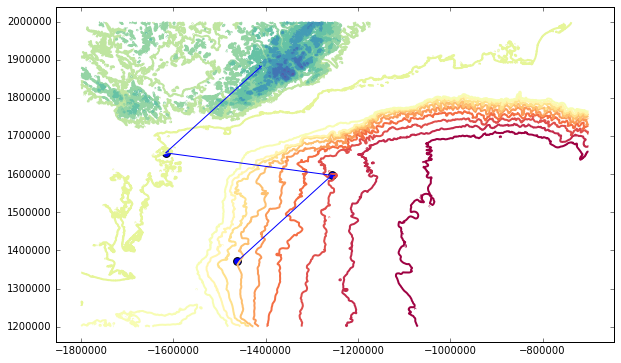

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.contour(xn,yn,zn,20,linewidths=2,cmap=cm.Spectral)
ax.scatter(lon_stere, lat_stere, s=60)
ax.plot(lon_stere, lat_stere)